# Newton's method, and Gauss-Newton algorithm

This notebook includes simple implementations of Newton's method and Gauss-Newton algorithm.

## Newton's method
Newton's method is an iterative zero-finding method. Given a function $F$ and its Jacobian $DF$, and a initial condition $x_0$, from step $n$ to $n+1$, it does the step:
$$
x_{n+1} = x_n - DF(x_n)^{-1}F(x_n).
$$

$x$ can be multidimensional. If $x$ is a vector with dimension $d$, $F(x)$ is then also a vector with the same size, and $DF(x)$ being the $d\times d$ Jacobian matrix.

Below shows an implementation:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def Newton_system(F, J, x, eps,plot=False):
    """
    Solve nonlinear system F=0 by Newton's method.
    J is the Jacobian of F. Both F and J must be functions of x.
    At input, x holds the start value. The iteration continues
    until ||F|| < eps.
    """
    F_value = F(x)
    F_norm = np.linalg.norm(F_value, ord=2)  # L2 norm of vector
    F_table = [F_norm]
    iteration_counter = 0
    xpath = [x]
    while abs(F_norm) > eps and iteration_counter < 100:
        delta = np.linalg.solve(J(x), -F_value)   # Solve J_n delta = -F_n, with delta = x_{n+1}-x_n 
        x = x + delta
        xpath = xpath + [x]
        F_value = F(x)
        F_norm = np.linalg.norm(F_value, ord=2)
        iteration_counter += 1
        F_table = F_table + [F_norm] 
        #print('Norm of F at iter {}:'.format(iteration_counter))
        #print('{}\n'.format(F_norm))
        
    # Here, either a solution is found, or too many iterations
    if abs(F_norm) > eps:
        iteration_counter = -1
    
    if plot:
        
        plt.semilogy(F_table,'o-')
        plt.xlabel('Niter')
        plt.ylabel('Norm of F')
        plt.grid()
        plt.show()

        xg = np.linspace(0.3,2.5,200)
        yg = np.linspace(-2,1,200)
        X,Y = np.meshgrid(xg,yg)
        Z = F( [X] + [Y] ) 
        Z = np.sqrt(Z[0]**2 + Z[1]**2)
    
        plt.contour(X,Y,Z)
        plt.colorbar()
        for i in range(iteration_counter):
            plt.plot([xpath[i][0],xpath[i+1][0]],[xpath[i][1],xpath[i+1][1]],'o-',label = 'iter {}'.format(i+1))
        plt.legend()
        plt.xlabel(r'$x_0$')
        plt.ylabel(r'$x_1$')
        
        plt.show()
        
    return x, iteration_counter

### Example
Now let's try Newton's method on the following 2D function of $\bf x = [x_1,x_2]$: 
    $$
    F({\bf x}) = [  F_0 , F_1   ],\quad 
    F_0({\bf x}) = x_0^2 - x_1 + x_0 \cos (\pi x_0),\quad 
    F_1({\bf x}) = x_0x_1 + \exp (-x_1) - 1/x_0.
    $$
Its Jacobian is:
    $$
    DF({\bf x}) = 
    \begin{bmatrix} 
    2x_0 + \cos (\pi x_0) - \pi x_0 \sin (\pi x_0 ) & -1 \\
    x_1 + \frac{1}{x_0^2} & x_0 - \exp (-x_1)
    \end{bmatrix}.
    $$
It has a zero at $x_0 = 1$ and $x_1 = 0$.

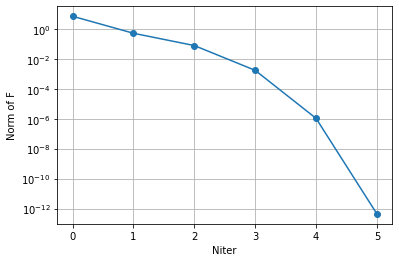

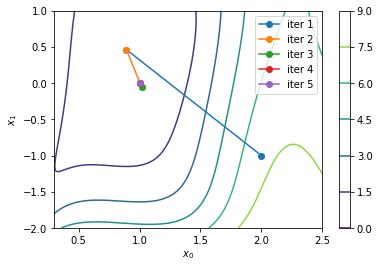

In [3]:
def F(x):
    return np.array(
        [  x[0]**2 - x[1] + x[0]*np.cos(np.pi*x[0]),
           x[0]*x[1] + np.exp(-x[1]) - 1/x[0]  ])

def DF(x):
    return np.array(
        [ [2*x[0] + np.cos(np.pi*x[0]) - np.pi*x[0]*np.sin(np.pi*x[0]),   -1],
          [x[1] + 1/(x[0]**2),     x[0] - np.exp(-x[1])] ])

expected = np.array([1, 0])
tol = 1e-4
x, n = Newton_system(F, DF, x=np.array([2, -1]), eps=0.0000001, plot = True)

## Gauss-Newton algorithm
Gauss-Newton algorithm is one application of Newton's method on nonlinear least square problems. Given data $t_i$ and $y_i$, we would like to propose a model $\phi$ with parameters $\theta$, such that the sum of the square of the residues is minimized. The parameters are chosen optimally as
$$
\theta^* = \arg \min_{\theta} C(\theta),\quad C(\theta) = \sum_i ( \phi(t_i,\theta ) - y_i)^2.
$$
Here $\theta $ can be a vector.

In [4]:
# Cost function
def cost(ydat,ymod):
    return np.sum( (ydat-ymod)**2 )

If the cost function has a unique minimizer, then we only need to find the critical points, i.e. :
$$
\forall j,\quad \frac{\partial C}{\partial \theta_j} = 2 \sum_i [ \phi(t_i,\theta) - y_i  ]\frac{\partial \phi(t_i,\theta)}{\partial \theta_j} = 0.
$$
This is a zero-finding problem! We can apply our Newton's method here.

The Jacobian of these partial derivatives is given by:
$$
DF_{jk} = \frac{\partial^2 C}{\partial \theta_j\partial \theta_k } \approx 2\sum_i \frac{\partial \phi(t_i,\theta)}{\partial \theta_j}\frac{\partial \phi(t_i,\theta)}{\partial \theta_k}.
$$
With this approximation for Jacobian, the only quantity that we need to calculate is the partial derivatives of model with respect to the parameters.



### Example
Now let's try the algorithm on a 1D nonlinear regression problem with 3 parameters. The model is given by:

$$
y = \exp ( -1/4t) \cos (\pi t) + 0.5 + 0.2\epsilon,\quad \epsilon \sim U[0,1].
$$

We can try to use the model:
$$
\phi (t,\theta) = \exp(\theta_0 t) \cos(\theta_1 t) + \theta_2,
$$
and the truth should be $\theta_0 = -1/4$, $\theta_1 = \pi$ and $\theta_2 = 0.6$.

In [6]:
def model(t,theta):
    return np.exp(theta[0]*t)*np.cos(theta[1]*t ) + theta[2]

def model_deriv(t,theta):
    return np.array( [ 
                       t*np.exp(theta[0]*t)*np.cos(theta[1]*t),
                     - t*np.exp(theta[0]*t)*np.sin(theta[1]*t),
                        [1]*np.shape(t)[0]
                     ])

def DC(theta):
    r =  model(t,theta) - y
    J = model_deriv(t,theta)
    return 2*J.dot(r)

def DDC(theta):
    J = model_deriv(t,theta)
    return 2*J.dot(J.T)


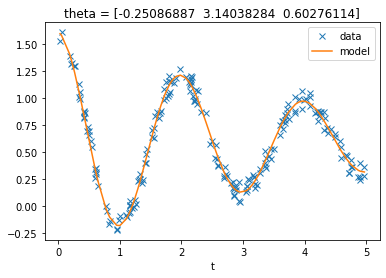

In [7]:
N = 200
t = 5*np.random.random(N)
t = np.sort(t)
y = np.exp(-1/4*t)*np.cos(np.pi*t ) + np.random.random(N)*0.2 + 0.5

theta0 = np.array([-1,3,0])
#expected = np.array([1, 0])
theta, n = Newton_system(DC, DDC, x=theta0, eps=0.001, plot = False)
plt.plot(t,y,'x',label = 'data')
plt.plot(t,model(t,theta),label = 'model')
plt.title('theta = {}'.format(theta))
plt.xlabel('t')
plt.legend()
plt.show()

Or one can use the 'curve_fit' function from scipy which does the same:

In [6]:
import scipy.optimize
def model2(t,a,b,c):
    return model(t,np.array([a,b,c]))
params = scipy.optimize.curve_fit(model2,t,y)
params[0]

array([-0.25832059,  3.13966245,  0.59075542])

There are cases that we don't know the derivative of the model! For example, we sometimes have ODE models, e.g. ODE models with unknown analytical solutions, etc. In this case we can use finite difference to approximate the derivatives:

$$
\frac{\partial \phi }{\partial \theta } \approx \frac{ \phi(\theta + \delta \theta) - \phi (\theta - \delta \theta ) }{2\delta \theta}.
$$

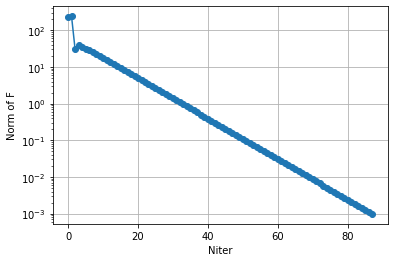

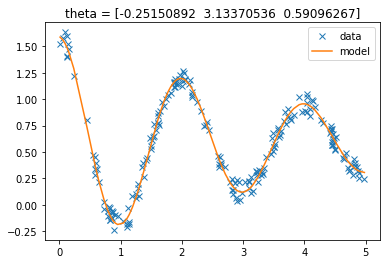

In [7]:
def model_deriv_approx(t,theta):
    phi = model(t,theta)
    
    res = []
    for i in range(np.shape(theta)[0]):
        dtheta = 1
        thetap = np.copy(theta) 
        thetap[i] -= dtheta
        thetaf = np.copy(theta)
        thetaf[i] += dtheta
        res = res + [  (model(t,thetaf)-model(t,thetap))/dtheta/2   ]
        
    return np.array(res)

def DC(theta):
    r =  model(t,theta) - y
    
    J = model_deriv_approx(t,theta)
    return 2*J.dot(r)

def DDC(theta):
    J = model_deriv_approx(t,theta)
    return 2*J.dot(J.T)


theta0 = np.array([-1,3,0])
#expected = np.array([1, 0])
theta, n = Newton_system(DC, DDC, x=theta0, eps=0.001, plot = False)
plt.plot(t,y,'x',label = 'data')
plt.plot(t,model(t,theta),label = 'model')
plt.title('theta = {}'.format(theta))
plt.legend()
plt.show()